In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
print(tf.__version__)
"""from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession"""

2.3.0


'from pyspark import SparkContext, SparkConf\nfrom pyspark.sql import SparkSession'

In [2]:
df = pd.read_csv("https://www.dropbox.com/s/bjk9tydkqrza8p8/IMDb_Reviews.csv?dl=1")
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [3]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.3, shuffle=True, random_state=2, stratify=df.sentiment)

In [4]:
print(train_data['sentiment'].value_counts())
print('-'*100)
print(test_data['sentiment'].value_counts())

1    17500
0    17500
Name: sentiment, dtype: int64
----------------------------------------------------------------------------------------------------
1    7500
0    7500
Name: sentiment, dtype: int64


In [5]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

training_sentences = np.array(train_data['review'])
testing_sentences = np.array(test_data['review'])

training_labels = np.array(train_data['sentiment'])
testing_labels = np.array(test_data['sentiment'])

In [6]:
vocab_size = 20000
embedding_dim = 16
max_length = 150
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [7]:
print(word_index['hello'])
print(word_index['awesome'])

5056
1166


In [8]:
print(sequences[1])

[181, 799, 17, 3745, 97, 5, 12, 561, 692, 13, 2, 113, 14, 11388, 76, 133, 150, 627, 197, 4, 50, 118, 2, 1025, 14, 881, 220, 10, 91, 23, 528, 138, 11, 502, 379, 23, 49, 2, 476, 109, 14, 374, 11, 90, 121, 117, 34, 165, 41, 535, 769, 244, 37, 12, 3, 140, 62, 9873, 1, 1, 308, 12, 7, 3745, 207, 9, 7, 2511]


In [9]:
print(padded[:20])
print('-'*100)
print(padded[1])

[[   11   215    12 ...     3   200     4]
 [    0     0     0 ...     9     7  2511]
 [ 9314     7  1166 ...  2557   135    13]
 ...
 [19414     1  1697 ...     1     6 12615]
 [  101   321     2 ...   205     3     2]
 [   12     7  4413 ...   201   330     8]]
----------------------------------------------------------------------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   181   799
    17  3745    97     5    12   561   692    13     2   113    14 11388
    76   133   150   627   197     4    50   118   

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print('-'*100)
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? quite typical for swedish movies of this type strange that the acting was soooo bad these actors usually give a good show the casting was poorly done it made you expect something i won't tell you what the lead character was awful i don't know where they find her anyway stay away from this and go see den <OOV> <OOV> instead this is swedish action in is prime
----------------------------------------------------------------------------------------------------
Quite typical for swedish movies of this type. Strange that the acting was soooo bad, these actors usually give a good show. The casting was poorly done, it made you expect something (I won't tell you what). The lead character was awful... I don't know where they find her. Anyway, stay away from this and go see "Den Tredje Vågen" instead, this is swedish action in is prime

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback() 

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=2e-3)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 256)          148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 542,861
Trainable params: 542,861
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))

In [14]:
num_epochs = 50
history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[
                                                                                                                             #lr_schedule, 
                                                                                                                             callbacks])

Epoch 1/50
1094/1094 [==============================] - 36s 33ms/step - loss: 0.6206 - accuracy: 0.6560 - val_loss: 0.6303 - val_accuracy: 0.6329
Epoch 2/50
1094/1094 [==============================] - 35s 32ms/step - loss: 0.4924 - accuracy: 0.7648 - val_loss: 0.3536 - val_accuracy: 0.8437
Epoch 3/50
1094/1094 [==============================] - 35s 32ms/step - loss: 0.2837 - accuracy: 0.8861 - val_loss: 0.3406 - val_accuracy: 0.8613
Epoch 4/50
1094/1094 [==============================] - 35s 32ms/step - loss: 0.2067 - accuracy: 0.9225 - val_loss: 0.3571 - val_accuracy: 0.8602
Epoch 5/50
1094/1094 [==============================] - 36s 33ms/step - loss: 0.1620 - accuracy: 0.9422 - val_loss: 0.3426 - val_accuracy: 0.8657
Epoch 6/50
1093/1094 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9563
Reached 95.0% accuracy so cancelling training!
1094/1094 [==============================] - 36s 33ms/step - loss: 0.1251 - accuracy: 0.9563 - val_loss: 0.3922 - val_accurac

In [15]:
import matplotlib.pyplot as plt
"""
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 2e-3, 0, 2])"""

'\nplt.semilogx(history.history["lr"], history.history["loss"])\nplt.axis([1e-3, 2e-3, 0, 2])'

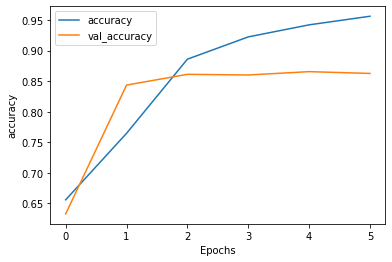

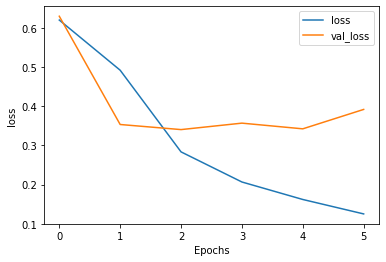

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [17]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(20000, 16)


In [18]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
"""try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')"""

"try:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')"

In [20]:
def predict_sentiment(text, model):
  testing_sentences=[]
  testing_sentences.append(text)
  testing_sentences = np.array(testing_sentences)
  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length)
  result = model.predict(testing_padded)
  if result>0.5:
    return "Liked it!", result
  else:
    return "Didn't like it.", result  
  

In [21]:
predict_sentiment("This movie was a waste of time!", model)

("Didn't like it.", array([[0.01084226]], dtype=float32))

In [22]:
predict_sentiment("This movie was terrific! I had a great time!", model)

('Liked it!', array([[0.97331154]], dtype=float32))